In [83]:
import numpy as np
import pandas as pd
import numpy.typing as npt
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import config
from battery_data import test, train, log_transformer

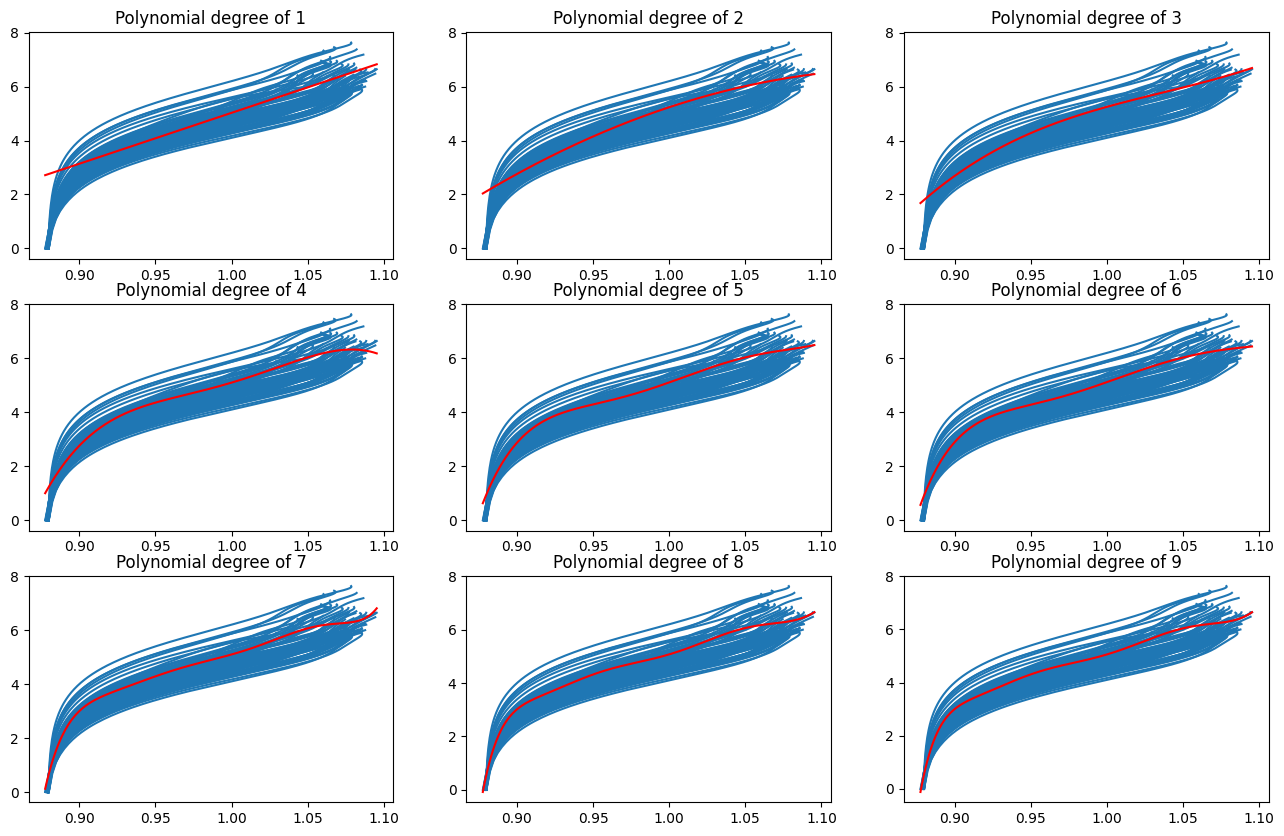

In [104]:
%matplotlib inline

N_SAMPLES = 200
FIGURE_ROWS = 3
FIGURE_COLUMNS = 3
MIN_POLYNOMIAL_DEGREE = 1
MAX_POLYNOMIAL_DEGREE = FIGURE_ROWS * FIGURE_COLUMNS
FIGSIZE = (16, 10)

plt.figure(figsize=FIGSIZE)

for plot_index, polynomial_degree in enumerate(range(MIN_POLYNOMIAL_DEGREE, MAX_POLYNOMIAL_DEGREE + 1)):
    polynomial_transformer = PolynomialFeatures(degree=polynomial_degree, include_bias=True)

    x = train.logged['capacity'].to_numpy()
    X = polynomial_transformer.fit_transform(x.reshape((-1, 1)))
    y = train.logged['RUL'].to_numpy()
    model = sm.OLS(y, X).fit()

    x_linspace = np.linspace(np.min(x), np.max(x), N_SAMPLES)
    x_axis = polynomial_transformer.fit_transform(x_linspace.reshape((-1, 1)))

    ax = plt.subplot(FIGURE_ROWS, FIGURE_COLUMNS, plot_index + 1)
    train.logged.groupby('battery_index').plot(x='capacity', y='RUL', ax=ax, color=config.TRUE_PLOT_COLOR, legend=False)
    ax.plot(x_linspace, model.predict(x_axis), color=config.PREDICTED_PLOT_COLOR)
    ax.set_title(f'Polynomial degree of {polynomial_degree}')
    ax.set_xlabel('')

plt.savefig(config.OUT_DIR / 'plots' / 'forward_regression_grid_transformed.png')
plt.show()

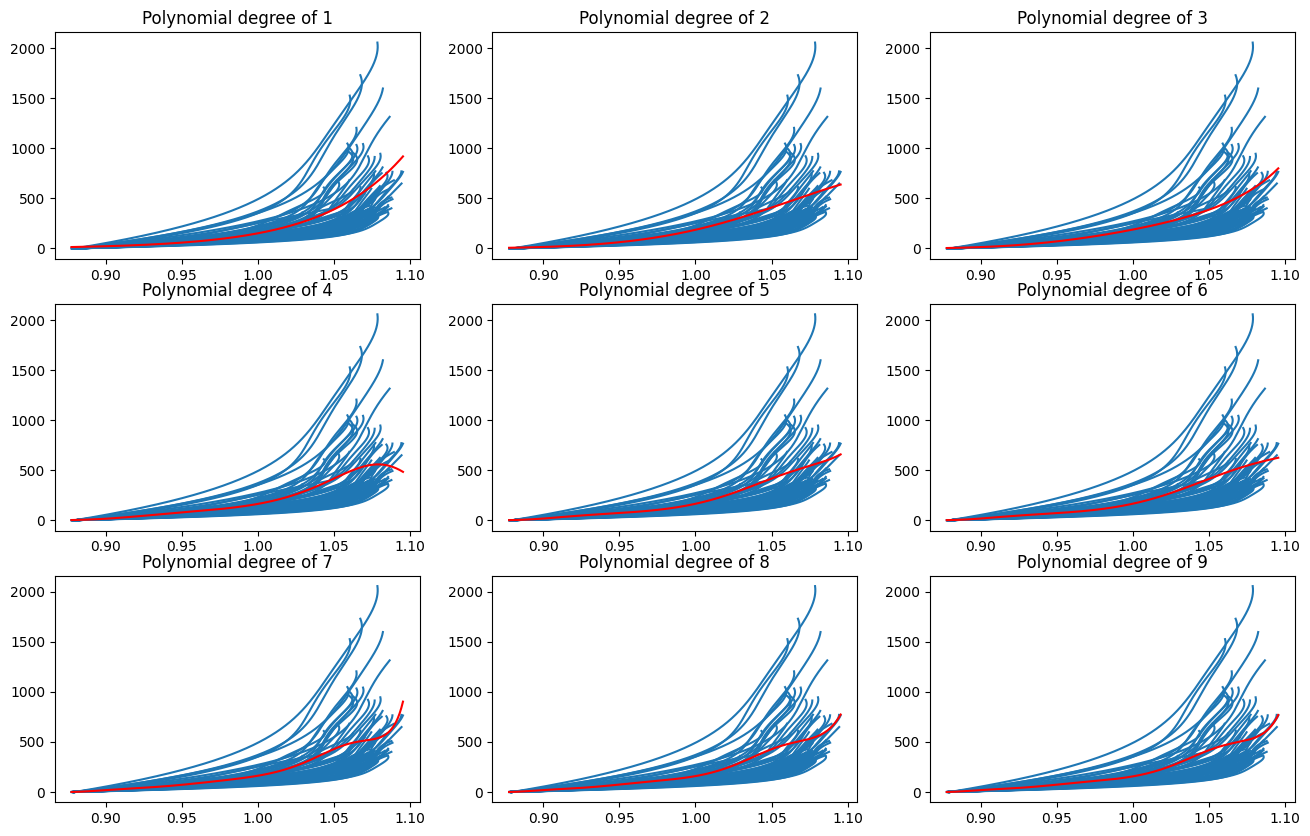

In [103]:
%matplotlib inline

plt.figure(figsize=FIGSIZE)

for plot_index, polynomial_degree in enumerate(range(MIN_POLYNOMIAL_DEGREE, MAX_POLYNOMIAL_DEGREE + 1)):
    polynomial_transformer = PolynomialFeatures(degree=polynomial_degree, include_bias=True)

    x = train.logged['capacity'].to_numpy()
    X = polynomial_transformer.fit_transform(x.reshape((-1, 1)))
    y = train.logged['RUL'].to_numpy()
    model = sm.OLS(y, X).fit()

    x_linspace = np.linspace(np.min(x), np.max(x), N_SAMPLES)
    x_axis = polynomial_transformer.fit_transform(x_linspace.reshape((-1, 1)))

    ax = plt.subplot(FIGURE_ROWS, FIGURE_COLUMNS, plot_index + 1)
    train.transformed.groupby('battery_index').plot(x='capacity', y='RUL', ax=ax, color=config.TRUE_PLOT_COLOR, legend=False)
    ax.plot(x_linspace, log_transformer.inverse_transform(model.predict(x_axis)), color=config.PREDICTED_PLOT_COLOR)
    ax.set_title(f'Polynomial degree of {polynomial_degree}')
    ax.set_xlabel('')

plt.savefig(config.OUT_DIR / 'plots' / 'forward_regression_grid.png')
plt.show()

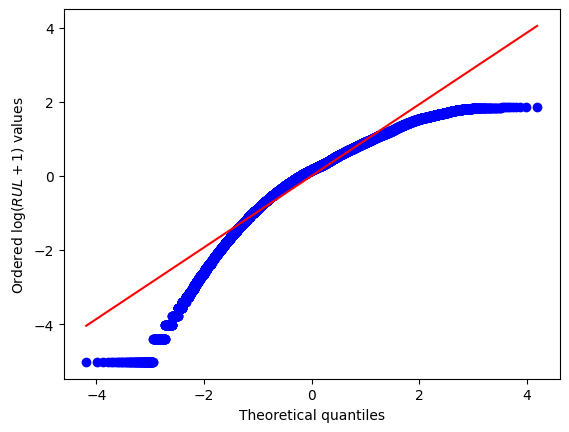

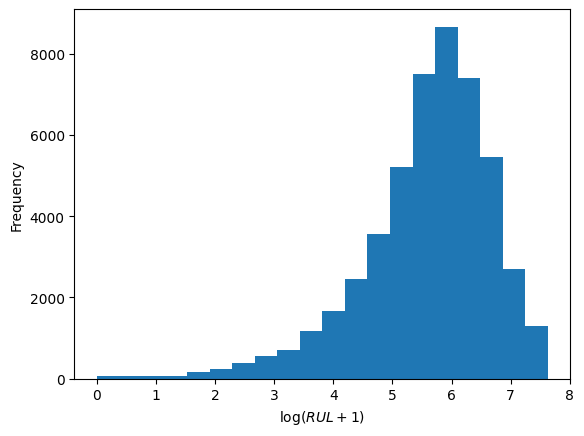

In [79]:
z = (train.logged['RUL'] - np.mean(train.logged['RUL'])) / np.std(train.logged['RUL'])
stats.probplot(z, dist='norm', plot=plt)
plt.title('')
plt.ylabel(r'Ordered $\log(RUL + 1)$ values')
plt.savefig(config.OUT_DIR / 'plots' / 'qq_plot_transformed_rul.png')
plt.show()

plt.hist(train.logged['RUL'], bins=20)
plt.xlabel(r'$\log(RUL + 1)$')
plt.ylabel('Frequency')
plt.savefig(config.OUT_DIR / 'plots' / 'histogram_transformed_rul.png')
plt.show()

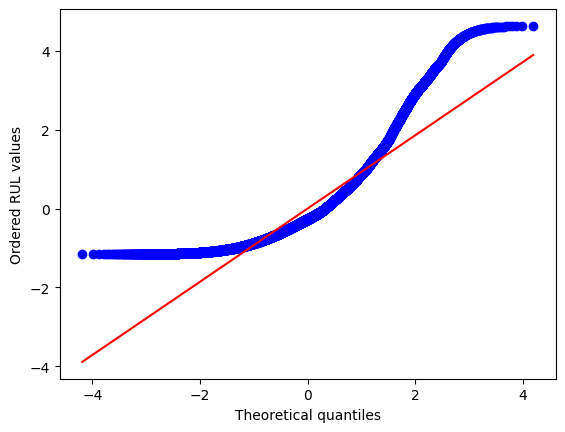

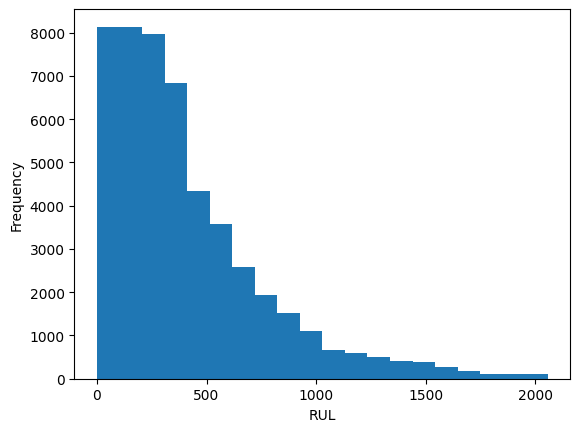

In [94]:
z = (train.transformed['RUL'].astype('float64') - np.mean(train.transformed['RUL'].astype('float64'))) / np.std(train.transformed['RUL'].astype('float64'))
stats.probplot(z, dist='norm', plot=plt)
plt.title('')
plt.ylabel('Ordered RUL values')
plt.savefig(config.OUT_DIR / 'plots' / 'qq_plot_rul.png')
plt.show()

plt.hist(train.transformed['RUL'].astype('float64'), bins=20)
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.savefig(config.OUT_DIR / 'plots' / 'histogram_rul.png')
plt.show()

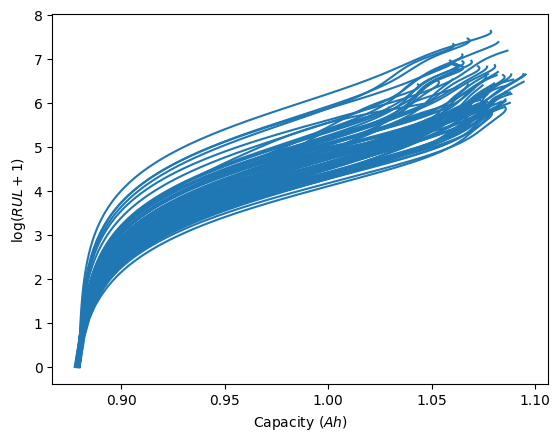

In [78]:
fig, ax = plt.subplots()
train.logged.groupby('battery_index').plot(x='capacity', y='RUL', ax=ax, color=config.TURQUOISE, legend=False)
ax.set_xlabel('Capacity ($Ah$)')
ax.set_ylabel(r'$\log(RUL + 1)$')
fig.savefig(config.OUT_DIR / 'plots' / 'capacity_rul_log_transform.png')

In [ ]:
n = len(true_RULs)
EPSILON = 1e-10

def get_prediction_interval(x, y_pred, alpha=0.05):
    # std = np.sqrt(np.sum((true_RULs - predicted_RULs) ** 2) / (n - 2) * (1 + 1 / n + (x - np.mean(capacity_points) ** 2 / np.sum((capacity_points - np.mean(capacity_points)) ** 2))))
    # quantile = stats.norm.ppf(1 - alpha / 2)
    # interval = quantile * std
    p = regression_model.POLYNOMIAL_DEGREE
    se = np.sqrt(np.sum((true_RULs - np.mean(predicted_RULs)) ** 2) / (n - p))
    interval = stats.t(df=n-p).ppf(1 - alpha / 2) * se * np.sqrt(1 + 1 / n + (x - np.mean(capacity_points)) ** 2 / np.sum((capacity_points - np.mean(capacity_points)) ** 2))
    upper = y_pred + interval
    lower = y_pred - interval
    return lower, upper

def get_confidence_interval(x, y_pred, alpha=0.05):
    p = regression_model.POLYNOMIAL_DEGREE
    se = np.sqrt(np.sum((true_RULs - np.mean(predicted_RULs)) ** 2) / (n - p))
    interval = stats.t(df=n-p).ppf(1 - alpha / 2) * se * np.sqrt(1 / n + (x - np.mean(capacity_points)) ** 2 / np.sum((capacity_points - np.mean(capacity_points)) ** 2))
    upper = y_pred + interval
    lower = y_pred - interval
    return lower, upper

convered_RULs = 0

for capacity, true_RUL, predicted_RUL in zip(capacity_points, true_RULs, predicted_RULs):
    lower, upper = get_prediction_interval(capacity, predicted_RUL)
    is_in_interval = (lower - EPSILON) <= true_RUL <= (upper + EPSILON)
    convered_RULs += 1 if is_in_interval else 0

coverage_percentage = convered_RULs / n * 100
print(f'{coverage_percentage=}')

In [ ]:
for plot_index, polynomial_degree in enumerate(range(MIN_POLYNOMIAL_DEGREE, MAX_POLYNOMIAL_DEGREE + 1)):
    polynomial_transformer = PolynomialFeatures(degree=polynomial_degree, include_bias=True)

    x = train.logged['capacity'].to_numpy()
    X = polynomial_transformer.fit_transform(x.reshape((-1, 1)))
    y = train.logged['RUL'].to_numpy()
    model = sm.OLS(y, X).fit()

    x_linspace = np.linspace(np.min(x), np.max(x), N_SAMPLES)
    x_axis = polynomial_transformer.fit_transform(x_linspace.reshape((-1, 1)))

    ax = plt.subplot(FIGURE_ROWS, FIGURE_COLUMNS, plot_index + 1)
    train.logged.groupby('battery_index').plot(x='capacity', y='RUL', ax=ax, color=config.TRUE_PLOT_COLOR, legend=False)
    ax.plot(x_linspace, model.predict(x_axis), color=config.PREDICTED_PLOT_COLOR)
    ax.set_title(f'Polynomial degree of {polynomial_degree}')
    ax.set_xlabel('')

plt.savefig(config.OUT_DIR / 'plots' / 'forward_regression_grid_transformed.png')
plt.show()